# Generative Adversarial Networks (GANs)

So far in CS1470, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence translation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repertoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data ($\sim$ just means 'drawn from' &mdash; so $x$ consists of our samples, each of which are 'drawn from' $p_\text{data}$, our entire set of input data.), $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. [Goodfellow et al.](https://arxiv.org/abs/1406.2661) analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

As a way to simplify the math, we **update the generator: maximize the probability of the discriminator making the incorrect choice**. This allows us to use two maximize functions as opposed to one minimize and one maximize. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling, check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is using Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

### Lab Details

For this lab, we'll just be implementing the simplest kind of GAN, but there are several variations that can yield better results.

Example GAN outputs (yours should look like the ones on the left):

![caption](gan_outputs_tf.png)

#### When you're finished with the lab, show your TA the ouputs of the sections marked **CHECKOFF** to get checked off.


## Setup

In [2]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which contains 60,000 training and 10,000 test images.

To simplify our code here, we will use the TensorFlow Keras MNIST dataset, which loads the MNIST dataset. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) for more information about the interface. 

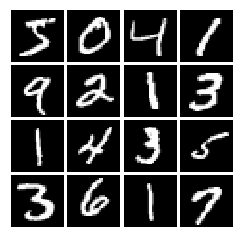

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_images, [train_images.shape[0], -1])
show_images(train_images[:16])
train_images = train_images / 255.0

mnist = tf.data.Dataset.from_tensor_slices(train_images)

## LeakyReLU
Rectified Linear Unit (ReLU) is a popular activation function that computes $f(x) = max(0, x)$. However, in some scenarios, neurons using this activation function may "die" &mdash; it will not activate on any data samples. In order to solve this problem, some researchers use **leaky ReLU**:

\begin{equation}
x = 
\left\{
             \begin{array}{lr}
             \alpha * x &, x < 0  \\
             x &, x > 0
             \end{array}
\right.
\end{equation}

Leaky ReLU attempts to fix dying neuron problem by having a small slope when $x < 0$. This is a general optimizat In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods(as are maxout units, however those increase model size and therefore are not used in this notebook. For more information about maxout units, you can refer to this [paper](https://arxiv.org/abs/1302.4389)).

Noted: Starting from version 1.4, Tensorflow supports a native [tf.nn.leaky_relu](https://www.tensorflow.org/api_docs/python/tf/nn/leaky_relu). For this lab, you should implement leaky ReLU by yourself.

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # Hint: try using tf.maximum
    return tf.maximum(alpha*x, x)
    

### CHECKOFF
Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform(shape=[batch_size, dim], minval=-1, maxval=1)
    

### CHECKOFF
Make sure noise is the correct shape and type:

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model. `tf.layers` offers you a convenient way to construct neural network layer by layer, while providing many different type layers. For example, you can create a fully connected layer with [`tf.layers.dense`](https://www.tensorflow.org/api_docs/python/tf/layers/dense).

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
Note: all fully connected layers should include bias terms. The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [8]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc_1 = tf.layers.dense(x, 256, use_bias=True, activation=leaky_relu)
        fc_2 = tf.layers.dense(fc_1, 256, use_bias=True, activation=leaky_relu)
        fc_3 = tf.layers.dense(fc_2, 1, use_bias=True)
        
        return fc_3

### CHECKOFF

Test to make sure the number of parameters in the discriminator is correct:

In [9]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [10]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc_1 = tf.layers.dense(z, 1024, use_bias=True, activation=tf.nn.relu)
        fc_2 = tf.layers.dense(fc_1, 1024, use_bias=True, activation=tf.nn.relu)
        fc_3 = tf.layers.dense(fc_2, 784, use_bias=True, activation=tf.keras.activations.tanh)
        return fc_3
        

### CHECKOFF
Test to make sure the number of parameters in the generator is correct:

In [11]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing by using [tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

In [12]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: fill in D_loss and G_loss
    # Remember that the generator is trying to maximize the probability of the discriminator making the incorrect choice
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    return D_loss, G_loss

### CHECKOFF
Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [13]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 6.02597e-17
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [14]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [15]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [16]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # create iterator
    global mnist
    it = 0
    mnist = mnist.repeat(num_epoch).shuffle(batch_size).batch(batch_size)
    iterator = mnist.make_one_shot_iterator()
    next_element = iterator.get_next()
    try:
        while True:
            # every show often, show a sample result
            if it % show_every == 0:
                samples = sess.run(G_sample)
                fig = show_images(samples[:16])
                plt.show()
                print()
            # run a batch of data through the network
            minibatch = sess.run(next_element)
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
            it += 1
    except tf.errors.OutOfRangeError:
        print('Final images')
        samples = sess.run(G_sample)
        fig = show_images(samples[:16])
        plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

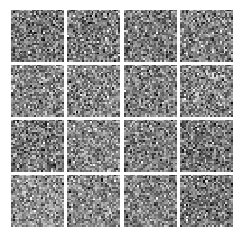


Iter: 0, D: 1.54, G:0.7178
Iter: 50, D: 0.3015, G:1.634
Iter: 100, D: 0.3783, G:2.426
Iter: 150, D: 1.394, G:1.148
Iter: 200, D: 1.81, G:1.247


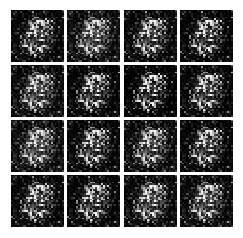


Iter: 250, D: 1.127, G:1.344
Iter: 300, D: 1.864, G:0.8966
Iter: 350, D: 1.03, G:1.769
Iter: 400, D: 3.09, G:0.159
Iter: 450, D: 1.103, G:1.81


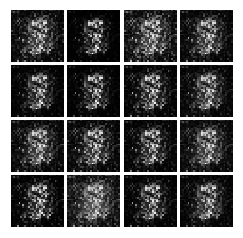


Iter: 500, D: 1.459, G:2.018
Iter: 550, D: 1.66, G:2.324
Iter: 600, D: 1.482, G:1.082
Iter: 650, D: 2.269, G:0.7966
Iter: 700, D: 0.8706, G:2.086


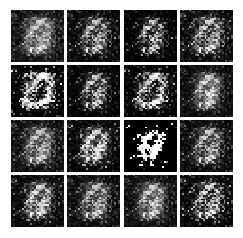


Iter: 750, D: 1.158, G:1.862
Iter: 800, D: 1.271, G:1.664
Iter: 850, D: 1.198, G:0.8915
Iter: 900, D: 1.242, G:1.197
Iter: 950, D: 1.287, G:1.039


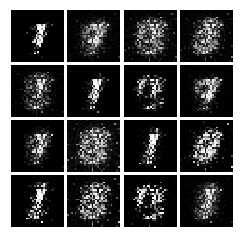


Iter: 1000, D: 1.141, G:2.625
Iter: 1050, D: 1.042, G:1.312
Iter: 1100, D: 1.218, G:1.155
Iter: 1150, D: 1.339, G:1.046
Iter: 1200, D: 1.732, G:1.468


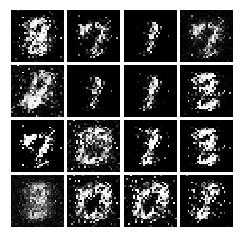


Iter: 1250, D: 1.121, G:1.259
Iter: 1300, D: 1.098, G:0.8988
Iter: 1350, D: 1.235, G:1.25
Iter: 1400, D: 1.818, G:0.7271
Iter: 1450, D: 1.183, G:0.8865


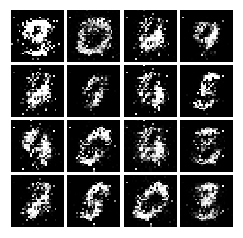


Iter: 1500, D: 1.321, G:0.9788
Iter: 1550, D: 1.393, G:1.03
Iter: 1600, D: 1.246, G:3.472
Iter: 1650, D: 1.014, G:0.9442
Iter: 1700, D: 1.262, G:1.063


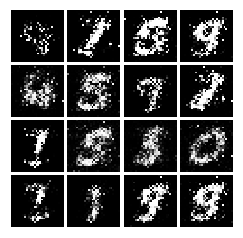


Iter: 1750, D: 1.09, G:1.023
Iter: 1800, D: 1.181, G:1.128
Iter: 1850, D: 1.151, G:1.101
Iter: 1900, D: 1.401, G:0.972
Iter: 1950, D: 1.219, G:1.155


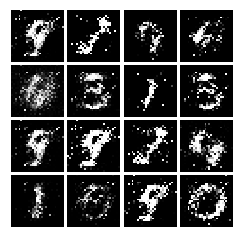


Iter: 2000, D: 1.516, G:1.207
Iter: 2050, D: 1.43, G:0.7956
Iter: 2100, D: 1.248, G:1.126
Iter: 2150, D: 1.121, G:1.021
Iter: 2200, D: 1.289, G:0.9178


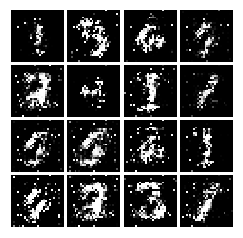


Iter: 2250, D: 1.263, G:1.419
Iter: 2300, D: 1.255, G:0.9542
Iter: 2350, D: 1.188, G:1.065
Iter: 2400, D: 1.422, G:1.788
Iter: 2450, D: 1.276, G:0.8787


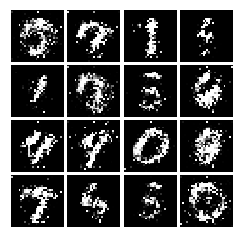


Iter: 2500, D: 1.271, G:0.9225
Iter: 2550, D: 1.359, G:0.8128
Iter: 2600, D: 1.269, G:0.8736
Iter: 2650, D: 1.202, G:0.5306
Iter: 2700, D: 1.348, G:0.7647


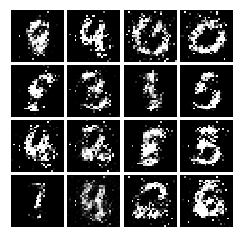


Iter: 2750, D: 1.321, G:0.7797
Iter: 2800, D: 1.231, G:0.8854
Iter: 2850, D: 1.43, G:0.9889
Iter: 2900, D: 1.236, G:0.5231
Iter: 2950, D: 1.299, G:1.084


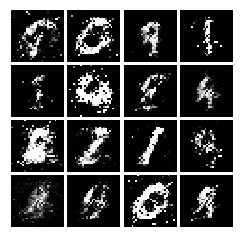


Iter: 3000, D: 1.304, G:0.9432
Iter: 3050, D: 1.359, G:0.8381
Iter: 3100, D: 1.394, G:0.8326
Iter: 3150, D: 1.347, G:0.7728
Iter: 3200, D: 1.305, G:0.9439


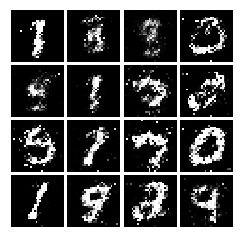


Iter: 3250, D: 1.338, G:0.8486
Iter: 3300, D: 1.289, G:0.8052
Iter: 3350, D: 1.337, G:0.8448
Iter: 3400, D: 1.282, G:0.9079
Iter: 3450, D: 1.27, G:0.9629


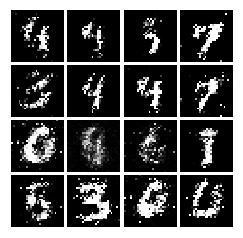


Iter: 3500, D: 1.308, G:0.8006
Iter: 3550, D: 1.414, G:0.6348
Iter: 3600, D: 1.365, G:0.7952
Iter: 3650, D: 1.216, G:0.9126
Iter: 3700, D: 1.389, G:0.8235


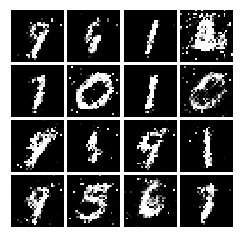


Iter: 3750, D: 1.303, G:0.8696
Iter: 3800, D: 1.4, G:0.8911
Iter: 3850, D: 1.402, G:0.7612
Iter: 3900, D: 1.243, G:0.831
Iter: 3950, D: 1.274, G:1.55


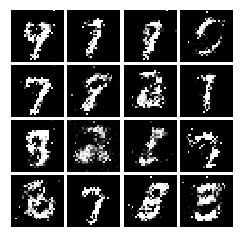


Iter: 4000, D: 1.396, G:0.7849
Iter: 4050, D: 1.181, G:0.8575
Iter: 4100, D: 1.355, G:0.9665
Iter: 4150, D: 1.307, G:0.9638
Iter: 4200, D: 1.317, G:0.8773


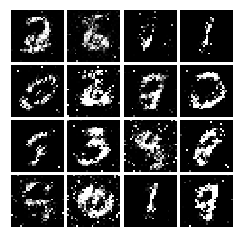


Iter: 4250, D: 1.175, G:0.6249
Iter: 4300, D: 1.305, G:0.8638
Iter: 4350, D: 1.274, G:1.025
Iter: 4400, D: 1.217, G:0.8233
Iter: 4450, D: 1.336, G:0.8161


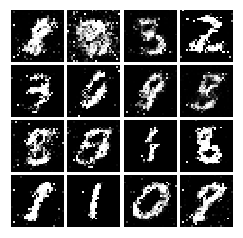


Iter: 4500, D: 1.324, G:0.901
Iter: 4550, D: 1.312, G:0.9158
Iter: 4600, D: 1.417, G:0.8745
Iter: 4650, D: 1.331, G:0.741
Final images


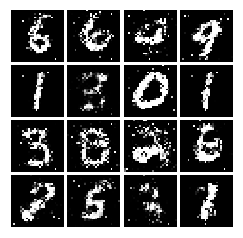

In [17]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

### CHECKOFF

Nice work! Show your TA your final images along with the outputs of the previous CHECKOFF sections to get checked off.

*This lab adapted from a CS231n Spring 2017 assignment.*